Detecting Dementia using Natural Language Processing - Machine Learning AL
<br> DAT550  Project </br>
<br> Group 3 Jupyter Notebook </br>
<br>Student Names :  </br>
- Nourin Mohammad
- Hengameh Hosseini
- Karam Tamim Yanis
- Dalya Al Mawed

In this notebook, we are going to explore the ADReSS Challenge Dataset to detect dementia using Natural Language Processing techniques.

The following dataset are provided to us:

- Control Transcripts
- Dementia Transcripts
- Testing

Note : This project was run in Google Collab Pro.


In [ ]:
# Access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import all the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, svm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

Functions for TFIDF Vectorization , Data Splitting and Data Size.


In [ ]:
# Convert the text into Training and testing data into vectors (numerical)
def FeatureVectorization(x_train, x_test):
    #  If max_features not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
    tfidf_Vectorizer = TfidfVectorizer(max_features= 300)

    # Convert the TF-IDF features to a DataFrame
    tfidf_train = tfidf_Vectorizer.fit_transform(x_train).toarray()

    # Transforming the test data
    tfidf_test = tfidf_Vectorizer.transform(x_test).toarray()

    return tfidf_train, tfidf_test


# This function will split the data first into training & Testing sets then apply TF-IDF vectorization
# if we have only one dataset and we need to split this data into two part we will assign Trainingdata = Dataset also the testingdata = Dataset
def SpiltData(TrainingData, TestingData, split_size= 0.80 ):
    x_train, y_train = TrainingData['Transcript'], TrainingData['Category']

    x_test, y_test = TestingData['Transcript'], TestingData['Category']

    # we use this option when the data is already separated into training & testing files
    if split_size == 1:  #  we apply vectorization for whole dataset without splitting
        x_train = x_train
        y_train = y_train
        x_test = x_test  # we will not use test set when we dont split the data
        y_test = y_test
    else: # if we have one file for both training & testing in this case we use the training
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size= split_size, stratify = y_train, random_state=42)

    # Get the  percentage for each set
    print('Training dataset:', x_train.shape, 'Testing dataset:', x_test.shape)
    print('-'*100)

    Control_cnt = y_train.value_counts()[0]
    print('Percentage of Control in train set is: ', round(Control_cnt/len(y_train) * 100, 2) , '% , with records count: ', Control_cnt)

    # Get the total number of Dementia_cnt count(label == 1)
    Dementia_cnt = y_train.value_counts()[1]
    print('Percentage of Dementia  in train set: ', round(Dementia_cnt/len(y_train) * 100, 2) , '% , with records count: ', Dementia_cnt)

    Control_cnt = y_test.value_counts()[0]
    print('Percentage of Control in test set: ', round(Control_cnt/len(y_test) * 100, 2) , '% , with records count: ', Control_cnt)

    # Get the total number of Dementia_cnt count(label == 1)
    Dementia_cnt = y_test.value_counts()[1]
    print('Percentage of Dementia in test set: ', round(Dementia_cnt/len(y_test) * 100, 2) , '% , with records count: ', Dementia_cnt)

    return x_train, x_test, y_train, y_test


# This function is splitting the Data into training & testing sets to get x_train, x_test, y_train, y_test
# Then we apply feature Vectorization to Convert the text in the Training and testing data into vectors (numerical)
#==================================================================
# split_size   : Percentage of the data used in the split functionality
def Spilt_vectorizationData(TrainingData, TestingData, split_size= 0.80):
    # First we split the Data
    x_train, x_test, y_train, y_test = SpiltData(TrainingData, TestingData, split_size= split_size)

    # Feature Extraction
    tfidf_train, tfidf_test = FeatureVectorization(x_train, x_test)
    return tfidf_train, tfidf_test, y_train, y_test



# print the percentage for control & dementia in the splitting data
def PrintDatasetSize(data, Dataname):
    # Count the occurrences of each label
    Control_cnt = data.value_counts()[0]
    Dementia_cnt = data.value_counts()[1]

    # Calculate the percentages
    control_percentage = round(Control_cnt / len(data) * 100, 2)
    dementia_percentage = round(Dementia_cnt / len(data) * 100, 2)

    # Plot the pie chart
    labels = ['Control', 'Dementia']
    sizes = [control_percentage, dementia_percentage]
    # #93C47D   # green, # #F6B26B orange , #8E7CC3 purple
    colors = ['#6FA8DC', '#E06666']
    explode = (0.1, 0)  # explode the first slice (Control)

    fig, ax = plt.subplots(figsize=(6, 4))
    wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                      shadow=True, startangle=140, textprops=dict(color="w"))


    ax.set_title(f'Percentage of (Control and Dementia) distribution in {Dataname}')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Custom legend
    legend_labels = [
        f'Control: {Control_cnt} ({control_percentage}%)',
        f'Dementia: {Dementia_cnt} ({dementia_percentage}%)'

    ]
    #ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(0.90, 0.5), fontsize='small', frameon=False)
    ax.legend(legend_labels, loc="center left", bbox_to_anchor=(0.9, 0.5), fontsize='small')
    plt.show()

    print('-' * 100)
    #print(Control_cnt / len(data) * 100, Control_cnt)
    # Print the percentages and counts
    print(f'Percentage of Control in {Dataname} set: {control_percentage}%, with records count: {Control_cnt}')
    print(f'Percentage of Dementia in {Dataname} set: {dementia_percentage}%, with records count: {Dementia_cnt}')
    print('-' * 100)

In [ ]:
# Import the ADReSS Dataset
df_control = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Control_db.csv')
df_dementia = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dementia_db.csv')
df_testing = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Testing_db.csv')

In [ ]:
# View the dataset
df_control.head()

,Language,Data,Participant,Age,Gender,Diagnosis,Category,mmse,Filename,Transcript
0,eng,Pitt,PAR,74,male,Control,0,NaN,S001,well there's a mother standing there &uh &uh ...
1,eng,Pitt,PAR,62,female,Control,0,30.0,S002,somebody's getting cookies out_of the cookie ...
2,eng,Pitt,PAR,69,female,Control,0,29.0,S003,okay . there's a little boy and <he's getting...
3,eng,Pitt,PAR,71,female,Control,0,30.0,S004,are you ready ? &um well the sink is overflow...
4,eng,Pitt,PAR,74,female,Control,0,30.0,S005,okay . <many &dish or> [//] the mother's wash...


## Pre-processing and Cleaning

- Explore the dataset and do some visualization to gain insights from the data.
- Check for outliers and remove them.
- Check for missing / null values and fill them
- Clean the "Transcript" columns ( lowercase, remove punctuations, stopwords)
- Add "word_count" column


<ipython-input-114-fffad3c4dc8d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(x='Diagnosis', data=df_dementia,  palette='inferno')


(54, 10)

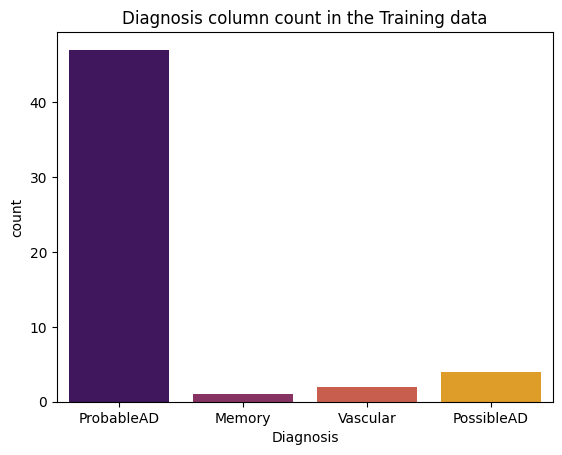

In [ ]:
graph = sns.countplot(x='Diagnosis', data=df_dementia,  palette='inferno')

# Plot Settings
plt.title('Diagnosis column count in the Training data')
df_dementia.shape

<ipython-input-115-f2c6d165bf04>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(x='Diagnosis', data=df_dementia, palette='inferno' )


(51, 10)

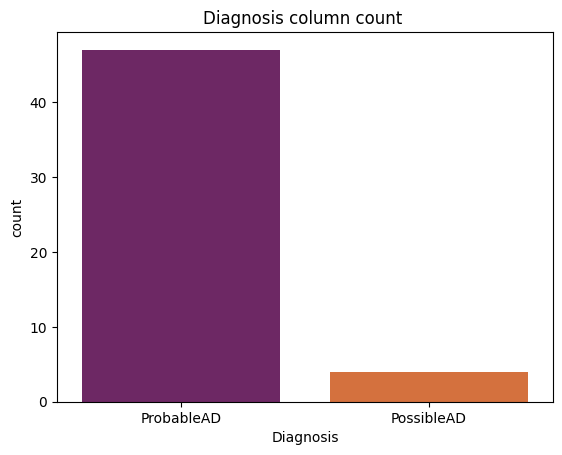

In [ ]:
# We do no require "Memory" and "Vascular" diagnosis, so we filter to select only 'ProbableAD', 'PossibleAD' from Dementia data
df_dementia = df_dementia[df_dementia['Diagnosis'].isin(['ProbableAD', 'PossibleAD'])]
graph = sns.countplot(x='Diagnosis', data=df_dementia, palette='inferno' )

# Plot Settings
plt.title('Diagnosis column count ')  #Title
df_dementia.shape

In [ ]:
# check null values
# Information about the dataset (columns, nun-null for each columns, DataType)
# ASs observed there are no null values.
df_dementia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 0 to 53
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Language     51 non-null     object
 1   Data         51 non-null     object
 2   Participant  51 non-null     object
 3   Age          51 non-null     int64 
 4   Gender       51 non-null     object
 5   Diagnosis    51 non-null     object
 6   Category     51 non-null     int64 
 7   mmse         51 non-null     int64 
 8   Filename     51 non-null     object
 9   Transcript   51 non-null     object
dtypes: int64(3), object(7)
memory usage: 4.4+ KB


In [ ]:
# check Null values for Control Dataset
df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Language     54 non-null     object 
 1   Data         54 non-null     object 
 2   Participant  54 non-null     object 
 3   Age          54 non-null     int64  
 4   Gender       54 non-null     object 
 5   Diagnosis    54 non-null     object 
 6   Category     54 non-null     int64  
 7   mmse         53 non-null     float64
 8   Filename     54 non-null     object 
 9   Transcript   54 non-null     object 
dtypes: float64(1), int64(2), object(7)
memory usage: 4.3+ KB


In [ ]:
# Fill the missing value for mmse and check again
df_control["mmse"].fillna(value = df_control["mmse"].mean(), inplace= True)
df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Language     54 non-null     object 
 1   Data         54 non-null     object 
 2   Participant  54 non-null     object 
 3   Age          54 non-null     int64  
 4   Gender       54 non-null     object 
 5   Diagnosis    54 non-null     object 
 6   Category     54 non-null     int64  
 7   mmse         54 non-null     float64
 8   Filename     54 non-null     object 
 9   Transcript   54 non-null     object 
dtypes: float64(1), int64(2), object(7)
memory usage: 4.3+ KB


<ipython-input-118-e9ff2e3e3346>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_control["mmse"].fillna(value = df_control["mmse"].mean(), inplace= True)


 Merge Dementia data with control data after shuffling into one data frame Training


In [ ]:
df_training = pd.concat([df_control, df_dementia], ignore_index=True)

# Shuffle the concatenated DataFrame
df_training = df_training.sample(frac=1).reset_index(drop=True)

print("Record Count in Training Data:", df_training.shape[0])
df_training.head()

Record Count in Training Data: 105


,Language,Data,Participant,Age,Gender,Diagnosis,Category,mmse,Filename,Transcript
0,eng,Pitt,PAR,73,female,Control,0,30.0,S024,alright . &um the mother is standing at the k...
1,eng,Pitt,PAR,72,female,Control,0,28.0,S070,beginning now ? boy is getting [//] reaching ...
2,eng,Pitt,PAR,57,female,Control,0,30.0,S041,water's pouring out_of the sink . and the wom...
3,eng,Pitt,PAR,69,female,Control,0,29.0,S003,okay . there's a little boy and <he's getting...
4,eng,Pitt,PAR,75,male,Control,0,29.0,S072,you mean right now tell you ? &uh the boy is ...


In [ ]:
# Information about the training dataset
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Language     105 non-null    object 
 1   Data         105 non-null    object 
 2   Participant  105 non-null    object 
 3   Age          105 non-null    int64  
 4   Gender       105 non-null    object 
 5   Diagnosis    105 non-null    object 
 6   Category     105 non-null    int64  
 7   mmse         105 non-null    float64
 8   Filename     105 non-null    object 
 9   Transcript   105 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 8.3+ KB


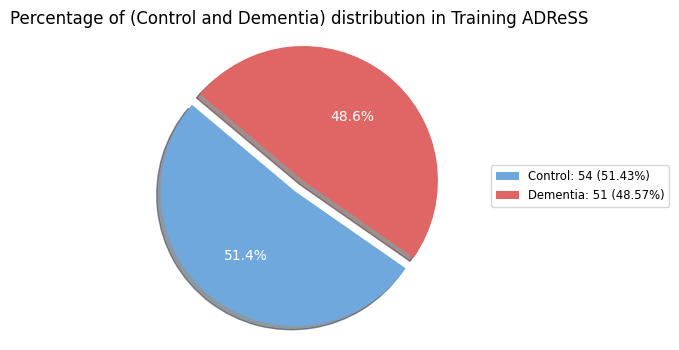

----------------------------------------------------------------------------------------------------
Percentage of Control in Training ADReSS set: 51.43%, with records count: 54
Percentage of Dementia in Training ADReSS set: 48.57%, with records count: 51
----------------------------------------------------------------------------------------------------


In [ ]:
PrintDatasetSize(df_training["Category"], 'Training ADReSS')


Explore and Visualize the Training Data

<ipython-input-122-ddcb970558c9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(x='Category', data=df_training, palette='inferno')


Text(0.5, 1.0, 'Diagnosis column count in Training ADReSS data \n (0: Control ; 1: ProbableAD)')

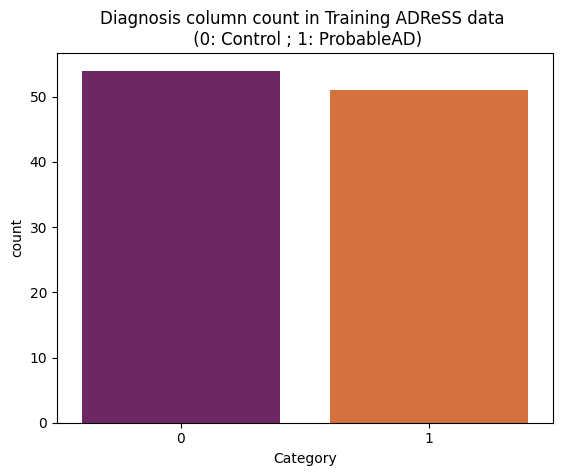

In [ ]:
graph = sns.countplot(x='Category', data=df_training, palette='inferno')

# Plot Settings
plt.title('Diagnosis column count in Training ADReSS data \n (0: Control ; 1: ProbableAD)')

<ipython-input-123-948a8fd6c73b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(x='Gender', data=df_training, palette='inferno')


Text(0.5, 1.0, 'Gender distribution count in ADReSS data')

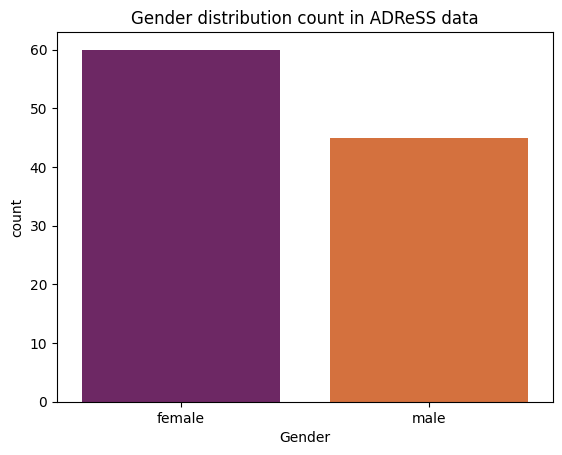

In [ ]:
graph = sns.countplot(x='Gender', data=df_training, palette='inferno')

# Plot Settings
plt.title('Gender distribution count in ADReSS data')

<ipython-input-124-9be6e48f1ddf>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(y='Age', data=df_training, palette='inferno')


Text(0.5, 1.0, 'Ages count in ADReSS data')

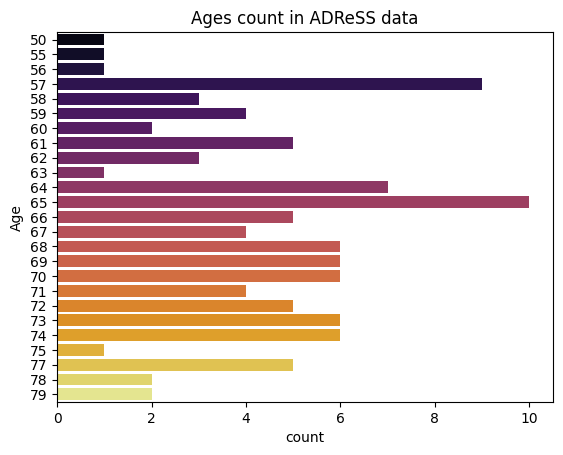

In [ ]:
graph = sns.countplot(y='Age', data=df_training, palette='inferno')
plt.title('Ages count in ADReSS data')  #Title

<ipython-input-125-68d4b471b02f>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(y='mmse', data=df_training, palette='inferno')


Text(0.5, 1.0, 'mmse count in ADReSS data')

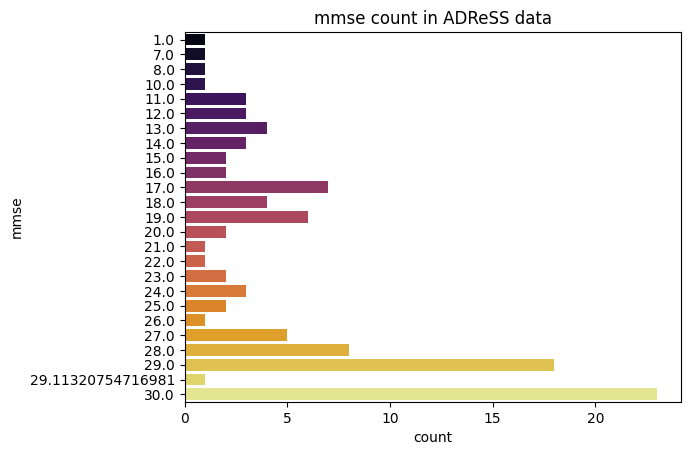

In [ ]:
graph = sns.countplot(y='mmse', data=df_training, palette='inferno')
plt.title('mmse count in ADReSS data')


Explore and Visualize the Testing Data

In [ ]:
print("Record count in Testing Data: ", df_testing.shape[0])
df_testing.head()

Record count in Testing Data:  48


,Data,Participant,Age,Gender,Diagnosis,Category,mmse,Filename,Transcript
0,Pitt,PAR,63,female,Control,0,28,S160,&uh this boy is about to fall off o(f) the st...
1,Pitt,PAR,55,female,Control,0,29,S161,&uh a boy with a cookie in his one hand and h...
2,Pitt,PAR,67,female,ProbableAD,1,24,S162,"I see &uh two kids up at the cookie jar, one ..."
3,Pitt,PAR,71,male,Control,0,30,S163,okay the water's running out_of the sink over...
4,Pitt,PAR,73,female,ProbableAD,1,21,S164,well he's into the cookie jar and the [/] the...


In [ ]:
# Check if there are any null values
# Information about the dataset (columns, nun-null for each columns, DataType)
df_testing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Data         48 non-null     object
 1   Participant  48 non-null     object
 2   Age          48 non-null     int64 
 3   Gender       48 non-null     object
 4   Diagnosis    48 non-null     object
 5   Category     48 non-null     int64 
 6   mmse         48 non-null     int64 
 7   Filename     48 non-null     object
 8   Transcript   48 non-null     object
dtypes: int64(3), object(6)
memory usage: 3.5+ KB


<ipython-input-128-0c6517e7a329>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  graph = sns.countplot(x='Category', data=df_testing, palette='inferno')


Text(0.5, 1.0, 'Diagnosis column count in Testing ADReSS data \n (0: Control ; 1: ProbableAD)')

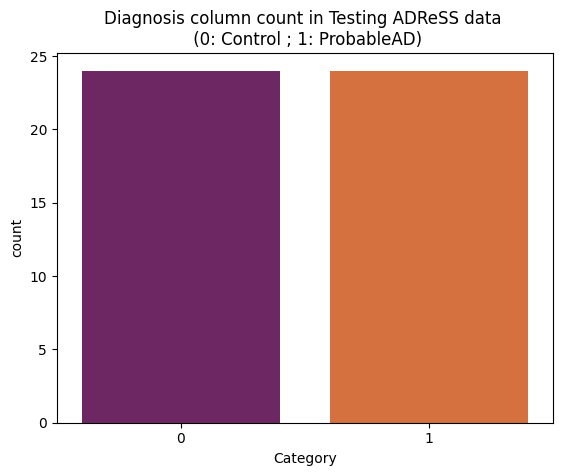

In [ ]:
graph = sns.countplot(x='Category', data=df_testing, palette='inferno')

# Plot Settings
plt.title('Diagnosis column count in Testing ADReSS data \n (0: Control ; 1: ProbableAD)')

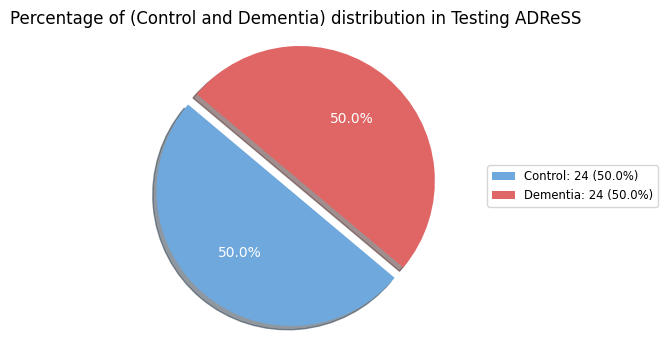

----------------------------------------------------------------------------------------------------
Percentage of Control in Testing ADReSS set: 50.0%, with records count: 24
Percentage of Dementia in Testing ADReSS set: 50.0%, with records count: 24
----------------------------------------------------------------------------------------------------


In [ ]:
PrintDatasetSize(df_testing["Category"], 'Testing ADReSS')


In [ ]:
# Adding word_count column to training and testing data to display the min & max word count for each transcript

def count_words(text):
    words = text.split()
    return len(words)

# Apply the count_words function to the 'transcript' column
df_training['word_count'] = df_training['Transcript'].apply(count_words)
df_testing['word_count'] = df_testing['Transcript'].apply(count_words)


In [ ]:
print("Descriptive statistics for training dataset")
df_training.describe()

Descriptive statistics for training dataset


,Age,Category,mmse,word_count
count,105.000000,105.000000,105.000000,105.000000
mean,66.628571,0.485714,23.172507,105.771429
std,6.424498,0.502193,7.191238,59.501981
min,50.000000,0.000000,1.000000,28.000000
25%,62.000000,0.000000,17.000000,63.000000
50%,67.000000,0.000000,27.000000,90.000000
75%,72.000000,1.000000,29.000000,132.000000
max,79.000000,1.000000,30.000000,446.000000


In [ ]:
print("Descriptive statistics for Testing dataset")
df_testing.describe()


Descriptive statistics for Testing dataset


,Age,Category,mmse,word_count
count,48.000000,48.000000,48.000000,48.000000
mean,66.125000,0.500000,24.125000,97.916667
std,7.186349,0.505291,6.125027,57.534017
min,50.000000,0.000000,10.000000,26.000000
25%,61.750000,0.000000,19.750000,58.000000
50%,67.000000,0.500000,27.000000,83.500000
75%,71.250000,1.000000,29.000000,128.250000
max,79.000000,1.000000,30.000000,358.000000


In [ ]:
# Calculate max and min for "mmse" where "Diagnosis" is "Control"
print("=============================================================================")
print("Display the max and min for MMSE for Control & ProbableAD in Training Dataset")
print("=============================================================================")
control_max = df_training[df_training['Category'] == 0]['mmse'].max()
control_min = df_training[df_training['Category'] == 0]['mmse'].min()

# Calculate max and min for "mmse" where "Diagnosis" is "ProbableAD"
probablead_max = df_training[df_training['Category'] == 1]['mmse'].max()
probablead_min = df_training[df_training['Category'] == 1]['mmse'].min()

# Print the results
print("Max mmse for Control:", control_max)
print("Min mmse for Control:", control_min)
print('-'*100)
print("Max mmse for ProbableAD:", probablead_max)
print("Min mmse for ProbableAD:", probablead_min)

Display the max and min for MMSE for Control & ProbableAD in Training Dataset
Max mmse for Control: 30.0
Min mmse for Control: 26.0
----------------------------------------------------------------------------------------------------
Max mmse for ProbableAD: 27.0
Min mmse for ProbableAD: 1.0


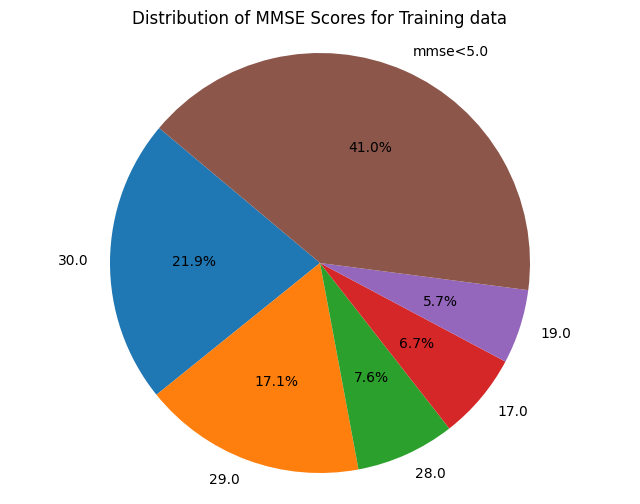

In [ ]:
# Count the occurrences of each value in the 'mmse' column
mmse_counts = df_training['mmse'].value_counts()

# Combine values less than 5% into one category
threshold = 0.05
total_count = mmse_counts.sum()
small_counts = mmse_counts[mmse_counts / total_count < threshold]
mmse_counts_combined = mmse_counts.drop(small_counts.index)
small_counts_total = small_counts.sum()
mmse_counts_combined['mmse<5.0'] = small_counts_total

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(mmse_counts_combined, labels=mmse_counts_combined.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of MMSE Scores for Training data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Calculate max and min for "mmse" where "Diagnosis" is "Control"
print("=============================================================================")
print("Display the max and min for MMSE for Control & ProbableAD in Testing Dataset")
print("=============================================================================")
control_max = df_testing[df_testing['Category'] == 0]['mmse'].max()
control_min = df_testing[df_testing['Category'] == 0]['mmse'].min()

# Calculate max and min for "mmse" where "Diagnosis" is "ProbableAD"
probablead_max = df_testing[df_testing['Category'] == 1]['mmse'].max()
probablead_min = df_testing[df_testing['Category'] == 1]['mmse'].min()

# Print the results
print("Max mmse for Control:", control_max)
print("Min mmse for Control:", control_min)
print('-'*100)
print("Max mmse for ProbableAD:", probablead_max)
print("Min mmse for ProbableAD:", probablead_min)

Display the max and min for MMSE for Control & ProbableAD in Testing Dataset
Max mmse for Control: 30
Min mmse for Control: 24
----------------------------------------------------------------------------------------------------
Max mmse for ProbableAD: 28
Min mmse for ProbableAD: 10


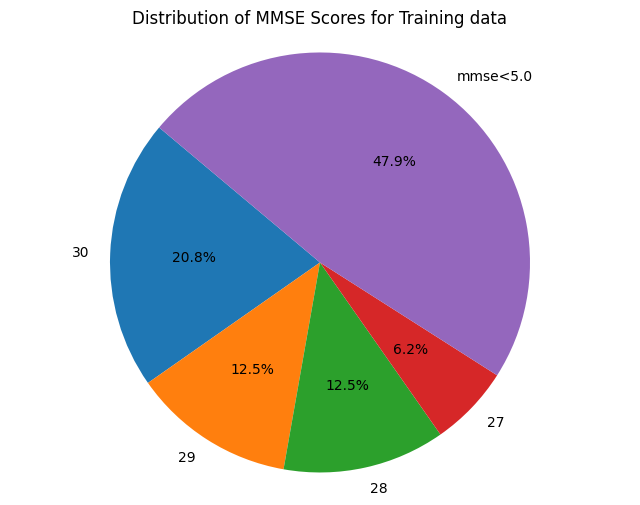

In [ ]:
# Count the occurrences of each value in the 'mmse' column
mmse_counts = df_testing['mmse'].value_counts()

# Combine values less than 5% into one category
threshold = 0.05
total_count = mmse_counts.sum()
small_counts = mmse_counts[mmse_counts / total_count < threshold]
mmse_counts_combined = mmse_counts.drop(small_counts.index)
small_counts_total = small_counts.sum()
mmse_counts_combined['mmse<5.0'] = small_counts_total

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(mmse_counts_combined, labels=mmse_counts_combined.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of MMSE Scores for Training data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Install libraries to clean the Transcript column
# Text cleaning : lowercase, remove stopwords and punctuations.
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Text Cleaning functions


def RemovePunctuations(text):
    text = text.lower()
    cleaned_text = re.sub(r'[^\w\s]', '', text)  # Remove all punctuation except underscores
    cleaned_text = re.sub(r' +', ' ', cleaned_text)
    return cleaned_text

# Initialize NLTK's stopwords and WordNetLemmatizer
sw = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def Remove_Stopword_lemmetize(text, bstopword = False):
    tokens = word_tokenize(text)
    if bstopword:
        filtered_tokens = [wnl.lemmatize(token) for token in tokens if token.lower() not in sw]
    else:
        filtered_tokens = [wnl.lemmatize(token.lower()) for token in tokens]
    return ' '.join(filtered_tokens)


# This function take two arguments the database and the column name
def preprocessing(df, colname, bstopword = False):
    df_process = df.copy()
    df_process[colname] = df_process.apply(lambda item: RemovePunctuations(item[colname]), axis=1)

    if bstopword:
        df_process[colname] = df_process.apply(lambda item: Remove_Stopword_lemmetize(item[colname], bstopword), axis=1)
    df_process = df_process.reset_index(drop = True)
    return df_process

In [ ]:
# Convert the categorical columns - Training Dataset
from sklearn.preprocessing import LabelEncoder
# (female :0, male: 1)
le = LabelEncoder()
df_training["Gender"] = le.fit_transform(df_training["Gender"])
df_training.describe()

,Age,Gender,Category,mmse,word_count
count,105.000000,105.000000,105.000000,105.000000,105.000000
mean,66.628571,0.428571,0.485714,23.172507,105.771429
std,6.424498,0.497245,0.502193,7.191238,59.501981
min,50.000000,0.000000,0.000000,1.000000,28.000000
25%,62.000000,0.000000,0.000000,17.000000,63.000000
50%,67.000000,0.000000,0.000000,27.000000,90.000000
75%,72.000000,1.000000,1.000000,29.000000,132.000000
max,79.000000,1.000000,1.000000,30.000000,446.000000


In [ ]:
# Get the max and min word count for the training data - before preprocessing
max_word_count = df_training['word_count'].max()
min_word_count = df_training['word_count'].min()

print("Maximum word count before preprocessing :", max_word_count)
print("Minimum word count before preprocessing :", min_word_count)

Maximum word count before preprocessing : 446
Minimum word count before preprocessing : 28


In [ ]:
# Apply Preprocessing to the Training Dataset and save it into a new
df_training = df_training.copy()
df_training = preprocessing(df_training, 'Transcript', True)
df_training['word_count'] = df_training['Transcript'].apply(count_words)

In [ ]:
# Get the max and min word count for the training data - after preprocessing
max_word_count = df_training['word_count'].max()
min_word_count = df_training['word_count'].min()

print("Maximum word count after preprocessing :", max_word_count)
print("Minimum word count after preprocessing :", min_word_count)

Maximum word count after preprocessing : 196
Minimum word count after preprocessing : 11


The word_count after preprocessing has now reduced. Given the context, a word_count less than 20 may not provide sufficient information for describing certain subjects, such as the Cookie Theft picture. This suggests that there are records with very brief descriptions that may not be descriptive enough.

In [ ]:
# Checking to see if the preprocessing of the text worked
df_training['Transcript']

,Transcript
0,alright um mother standing kitchen sink water ...
1,beginning boy getting reaching cooky stool fal...
2,water pouring out_of sink woman washing dish u...
3,okay there little boy he getting he standing h...
4,mean right tell uh boy stealing cooky out_of j...
...,...
100,okay well mother drying dish sink overflowing ...
101,alright little boy girl reaching shes got boy ...
102,water flowing floor shes drying dish he cookie...
103,gon na upset he trying get cookie sink running...


In [ ]:
# Now we do the same for the Testing dataset
# Convert the categorical columns - Training Dataset
from sklearn.preprocessing import LabelEncoder
# (female :0, male: 1)
le = LabelEncoder()
df_testing["Gender"] = le.fit_transform(df_testing["Gender"])
df_testing.describe()

,Age,Gender,Category,mmse,word_count
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,66.125000,0.458333,0.500000,24.125000,97.916667
std,7.186349,0.503534,0.505291,6.125027,57.534017
min,50.000000,0.000000,0.000000,10.000000,26.000000
25%,61.750000,0.000000,0.000000,19.750000,58.000000
50%,67.000000,0.000000,0.500000,27.000000,83.500000
75%,71.250000,1.000000,1.000000,29.000000,128.250000
max,79.000000,1.000000,1.000000,30.000000,358.000000


In [ ]:
# Get the max and min word count for the Testing data - before preprocessing
max_word_count = df_testing['word_count'].max()
min_word_count = df_testing['word_count'].min()

print("Maximum word count before preprocessing :", max_word_count)
print("Minimum word count before preprocessing :", min_word_count)

Maximum word count before preprocessing : 358
Minimum word count before preprocessing : 26


In [ ]:
# Apply Preprocessing to the Training Dataset and save it into a new
df_testing = df_testing.copy()
df_testing = preprocessing(df_testing, 'Transcript', True)
df_testing['word_count'] = df_testing['Transcript'].apply(count_words)

In [ ]:
# Get the max and min word count for the Testing data - after preprocessing
max_word_count = df_testing['word_count'].max()
min_word_count = df_testing['word_count'].min()

print("Maximum word count after preprocessing :", max_word_count)
print("Minimum word count after preprocessing :", min_word_count)

Maximum word count after preprocessing : 152
Minimum word count after preprocessing : 11


# Splitting Data
- Splitting the Dataset into Training & Testing sets if we have on dataset or if we already have two files one for training and one for testing we split each data into (X:feature, y: label)
-Vectorization :Convert the text into numerical representation by using TF-IDF Vectorization


In [ ]:
# Performing a K-FOLD Cross Validation
#==========================================
# 1. To Apply K-Fold on Training data first we use Tf IDF Feature vectorization for converting text to numeric

x_train, x_test, y_train, y_test = Spilt_vectorizationData(df_training, df_testing, 1)

Training dataset: (105,) Testing dataset: (48,)
----------------------------------------------------------------------------------------------------
Percentage of Control in train set is:  51.43 % , with records count:  54
Percentage of Dementia  in train set:  48.57 % , with records count:  51
Percentage of Control in test set:  50.0 % , with records count:  24
Percentage of Dementia in test set:  50.0 % , with records count:  24




```
# This is formatted as code
```

# Baseline: Apply Machine learning models and evaluation through Cross validation


In [ ]:
# This function used for applying machine learning models and evaluating them through k fold cross-validation
# we used 5 machine learning models
def BaseLineCrossValidation(splits =10, seed_num = 24, Metric_scoring = 'roc_auc'):
    #cv_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed_num)
    crossv_kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed_num)

    # Logistic regression
    LR_model = LogisticRegression(C= 10, random_state=seed_num)
    LR_scores = cross_val_score(LR_model, X = x_train, y = y_train, cv=crossv_kfold, scoring=Metric_scoring)

    # 2.Random Forest -RF
    if Metric_scoring == 'accuracy':
        RF_model = RandomForestClassifier( random_state=seed_num)
        #RF_model = RandomForestClassifier( n_estimators= 100, min_samples_leaf = 1, min_samples_split = 2, criterion = 'gini', random_state=seed_num)
    else:
        RF_model = RandomForestClassifier( n_estimators= 150, min_samples_leaf = 1, min_samples_split = 2, criterion = 'entropy', random_state=seed_num)
    RF_scores = cross_val_score(RF_model, X = x_train, y = y_train, cv=crossv_kfold, scoring=Metric_scoring)

    # KNN 15
    # metric in [‘euclidean’, ‘manhattan’, ‘minkowski’]

    KNN_model = KNeighborsClassifier(metric = "manhattan", n_neighbors=15)
    Knn_scores = cross_val_score(KNN_model, X = x_train, y = y_train, cv=crossv_kfold, scoring=Metric_scoring)
    #print(Knn_scores.mean())
    # Create an SVM classifier with specific hyperparameters
    #model = svm.SVC( kernel = 'sigmoid',  random_state=seed_num)#, probability=True)
    #kernel = ['poly', 'rbf', 'sigmoid']
    # C in [100, 10, 1.0, 0.1, 0.001]
    if Metric_scoring == 'accuracy':
        SVM_model = svm.SVC(kernel='linear', C=1.0, random_state=seed_num)
        #model = svm.SVC(degree=3, kernel='linear', C=1.0, probability=True)
    else:
        SVM_model = svm.SVC(kernel='sigmoid',  C=0.5, random_state=seed_num)
    svm_scores = cross_val_score(SVM_model, X = x_train, y = y_train, cv=crossv_kfold, scoring=Metric_scoring)

    if Metric_scoring == 'accuracy':
        NB_model = MultinomialNB()
    else:
        NB_model = MultinomialNB(force_alpha=True)
    NB_scores = cross_val_score(NB_model, X = x_train, y = y_train, cv=crossv_kfold, scoring=Metric_scoring)

    # Store all scoring values into dataframe
    ModelScoresDB = pd.DataFrame({
        'ML_Model': ["LR", "RF", "KNN", "SVM", "NB"],
        'Scoring': [LR_scores.mean(), RF_scores.mean(), Knn_scores.mean(), svm_scores.mean(), NB_scores.mean()]})

    #print('MODEL COMPARISON for BaseLine Models by using ', ModelScoresDB, ' score')
    return ModelScoresDB.sort_values(by='Scoring', ascending=False)


In [ ]:
sortedModels_10folds = BaseLineCrossValidation(splits =10, seed_num = 42, Metric_scoring = 'accuracy')
print("10 fold Cross validation results using accuracy scoring")
sortedModels_10folds

10 fold Cross validation results using accuracy scoring


,ML_Model,Scoring
0,LR,0.838182
3,SVM,0.819091
1,RF,0.818182
4,NB,0.808182
2,KNN,0.705455


In [ ]:
sortedModels_5folds = BaseLineCrossValidation(splits =5, seed_num = 42, Metric_scoring = 'accuracy')
print("5 fold Cross validation results using accuracy scoring")
sortedModels_5folds

5 fold Cross validation results using accuracy scoring


,ML_Model,Scoring
1,RF,0.847619
3,SVM,0.819048
0,LR,0.809524
4,NB,0.809524
2,KNN,0.704762


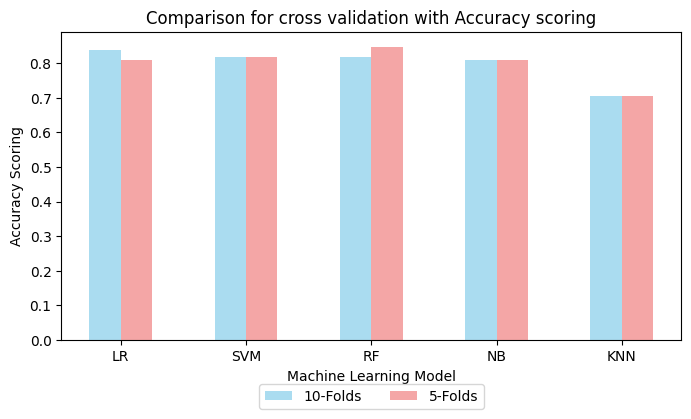

In [ ]:
# Merge the dataframes based on the 'ML_Model' column
merged_df = pd.merge(sortedModels_10folds, sortedModels_5folds, on='ML_Model', suffixes=('_10folds', '_5folds'))
merged_df.head()

# Set the width for the bars
bar_width = 0.25

# Calculate the positions for bars
bar_positions_10folds = range(len(merged_df))
bar_positions_5folds = [pos + bar_width for pos in bar_positions_10folds]

# Set custom colors
color_10folds = 'skyblue'
color_5folds = 'lightcoral'

fig, ax = plt.subplots(figsize=(8, 4))

# Plotting 10 folds results with custom color and width
ax.bar(bar_positions_10folds, merged_df['Scoring_10folds'], width=bar_width, label='10-Folds', color=color_10folds, alpha=0.7)

# Plotting 5 folds results with custom color and width
ax.bar(bar_positions_5folds, merged_df['Scoring_5folds'], width=bar_width, label='5-Folds', color=color_5folds, alpha=0.7)

# Adding labels and title
ax.set_xlabel('Machine Learning Model')
ax.set_ylabel('Accuracy Scoring')
ax.set_title('Comparison for cross validation with Accuracy scoring')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions_10folds])
ax.set_xticklabels(merged_df['ML_Model'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=False, ncol=2)


# Show the plot
plt.show()

In [ ]:
sortedModels_10folds = BaseLineCrossValidation(splits =10, seed_num = 42, Metric_scoring = 'roc_auc')
print("10 fold Cross validation results using roc_auc scoring")
sortedModels_10folds

10 fold Cross validation results using roc_auc scoring


,ML_Model,Scoring
3,SVM,0.928667
4,NB,0.924000
1,RF,0.913667
0,LR,0.912667
2,KNN,0.888667


In [ ]:
sortedModels_5folds = BaseLineCrossValidation(splits =5, seed_num = 42, Metric_scoring = 'roc_auc')
print("5 fold Cross validation results using roc_auc scoring")
sortedModels_5folds

5 fold Cross validation results using roc_auc scoring


,ML_Model,Scoring
3,SVM,0.912727
1,RF,0.911818
4,NB,0.903636
0,LR,0.894545
2,KNN,0.884545


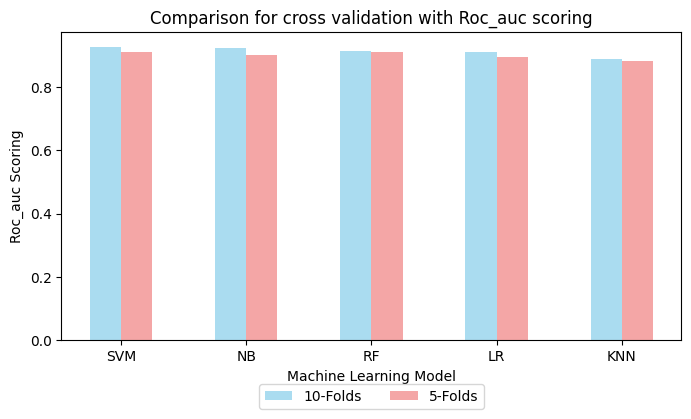

In [ ]:
# Merge the dataframes based on the 'ML_Model' column
merged_df = pd.merge(sortedModels_10folds, sortedModels_5folds, on='ML_Model', suffixes=('_10folds', '_5folds'))
merged_df.head()

# Set the width for the bars
bar_width = 0.25

# Calculate the positions for bars
bar_positions_10folds = range(len(merged_df))
bar_positions_5folds = [pos + bar_width for pos in bar_positions_10folds]

# Set custom colors
color_10folds = 'skyblue'
color_5folds = 'lightcoral'

fig, ax = plt.subplots(figsize=(8, 4))

# Plotting 10 folds results with custom color and width
ax.bar(bar_positions_10folds, merged_df['Scoring_10folds'], width=bar_width, label='10-Folds', color=color_10folds, alpha=0.7)

# Plotting 5 folds results with custom color and width
ax.bar(bar_positions_5folds, merged_df['Scoring_5folds'], width=bar_width, label='5-Folds', color=color_5folds, alpha=0.7)

# Adding labels and title
ax.set_xlabel('Machine Learning Model')
ax.set_ylabel('Roc_auc Scoring')
ax.set_title('Comparison for cross validation with Roc_auc scoring')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions_10folds])
ax.set_xticklabels(merged_df['ML_Model'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=False, ncol=2)


# Show the plot
plt.show()

Apply Machine Learning Model

In [ ]:
# Functions for ML Model
#===============================
# ApplyMachineL_Model Function
#===============================
# This function apply machinelearning algorithm.
# It takes 6 arguments Training data, Testing Data, Model Name,
# some argument to show or print some values like(accuracy scoring, confusion matrix)
# Arguments:
# X : dataset-features all columns except class column
# y : dataset-class column
# model name: Machine learning.
#===============================
def ApplyML_Model( X_train, X_test, y_train, Model = 'LR'):
    ModelName = ''

    # Apply Machine learning models
    if Model == 'LR':
        ModelName = 'LogisticRegression'

        #lr = LogisticRegression(C= 10, random_state=42)
        lr = LogisticRegression(random_state=42)
        lr.fit(X_train, y_train)
        y_predict = lr.predict(X_test)
        probs_model = lr.predict_proba(X_test)[:, 1]
        Spilt_vectorizationData
    if Model == 'RF':
        ModelName = 'RandomForestClassifier'

        #rf = RandomForestClassifier(criterion = 'entropy', random_state=42)
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train, y_train)
        y_predict = rf.predict(X_test)
        probs_model = rf.predict_proba(X_test)[:, 1]

    if Model == 'DT':
        ModelName = 'DecisionTree'
        #RF_model = RandomForestClassifier( n_estimators= 200, min_samples_leaf = 1, min_samples_split = 2, criterion = 'entropy', random_state=seed_num)
        #Best Parameters:  {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}
        #dt = DecisionTreeClassifier(criterion='entropy', max_depth= 30, max_features= 'sqrt', min_samples_split = 5, min_samples_leaf= 1,  random_state=42)
        dt = DecisionTreeClassifier(random_state=42)
        dt.fit(X_train, y_train)
        y_predict  = dt.predict(X_test)
        probs_model = dt.predict_proba(X_test)[:, 1]

    if Model == 'NB':
        ModelName = 'MultinomialNB'

        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        y_predict = nb.predict(X_test)
        probs_model = nb.predict_proba(X_test)[:, 1]


    #SVM [params: c = 1.0, kernel=RBF,gamma=scale]
    if Model == 'SVM':
        ModelName = 'Support Vector Machine'
        #svmach = svm.SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
        svmach = svm.SVC(probability=True, random_state=42)
        svmach.fit(X_train, y_train)
        y_predict = svmach.predict(X_test)
        probs_model = svmach.predict_proba(X_test)[:, 1]

    if Model == 'KNN':
        ModelName = 'KNeighborsClassifier'
        #knn = KNeighborsClassifier(metric = "manhattan", n_neighbors=15)
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        probs_model = knn.predict_proba(X_test)[:, 1]

    if Model == 'GBT':
        ModelName = 'GradientBoostingClassifier'

        gbt = GradientBoostingClassifier(random_state=42)
        gbt.fit(X_train, y_train)
        y_predict = gbt.predict(X_test)
        #y_validation_predict = gbt.predict(X_validation)
        probs_model = gbt.predict_proba(X_test)[:, 1]

    print('MachineLearning Model:',ModelName)
    print('='*100)
    return y_predict, probs_model


# Evaluation the ML models and print scores for(Accuracy, precision, Recall, F1-score)
# and print (classification report, confusionMatrix
def MLModel_Evaluation(y_predict, y_test, probs_model, ModelName, ShowReport, ConfusionMatrix):

    # PERFORMANCE EVALUATION  and calculate model metrics
    Test_Accuracy = accuracy_score(y_test, y_predict)
    Test_Recall_Score = recall_score(y_test, y_predict)
    Test_precision_Score = precision_score(y_test, y_predict)
    Test_f1_Score = f1_score(y_test, y_predict)
    Test_auc_score = roc_auc_score(y_test, probs_model)

    Metric_data = [
        ["Accuracy", f"{round(Test_Accuracy, 2):.2f}"],
        ["Precision_Score", f"{round(Test_precision_Score, 2):.2f}"],
        ["Recall_Score", f"{round(Test_Recall_Score, 2):.2f}"],
        ["F1_Score", f"{round(Test_f1_Score, 2):.2f}"],
        ["AUC_Score", f"{round(Test_auc_score, 2):.2f}"]
    ]

    print(tabulate(Metric_data, headers=[ModelName+ " Scoring", "Value"], tablefmt="pretty"))

    if ShowReport == True:
        print('\n Performance Report for model:', ModelName,'\n')
        print(classification_report(y_test, y_predict))

    # CONFUSION MATRIX
    if ConfusionMatrix == True:
        conf_matrix = confusion_matrix(y_test, y_predict)

        print('='*100)
        print('CONFUSION MATRIX')
        #print(conf_matrix)
         #Plot CONFUSION MATRIX
        categories = ['Control', 'AD']
        sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap = 'BuPu', xticklabels=categories, yticklabels=categories)
        plt.ylabel('Actual Value')
        plt.xlabel('Predicted value')
        plt.title('Confusion Matrix for :'+ ModelName)


    return Test_Accuracy, Test_precision_Score, Test_Recall_Score, Test_f1_Score

In [ ]:
# 1. After Splitting the dataset & Applying TfIDF vertorization
x_train, x_test, y_train, y_test = Spilt_vectorizationData(df_training, df_testing, 1)

print("feature dimension: ", len(x_train[0]))

Training dataset: (105,) Testing dataset: (48,)
----------------------------------------------------------------------------------------------------
Percentage of Control in train set is:  51.43 % , with records count:  54
Percentage of Dementia  in train set:  48.57 % , with records count:  51
Percentage of Control in test set:  50.0 % , with records count:  24
Percentage of Dementia in test set:  50.0 % , with records count:  24
feature dimension:  300


In [ ]:
# 2. Apply MachineLearning Model - Logistic Regression
Predict_LR, probs_LR = ApplyML_Model(x_train, x_test, y_train, Model = 'LR')

# 3. Evaluation the ML Model
Test_Accuracy_lr = MLModel_Evaluation(Predict_LR, y_test, probs_LR, ModelName='LogisticRegression', ShowReport = False, ConfusionMatrix=False)

MachineLearning Model: LogisticRegression
+----------------------------+-------+
| LogisticRegression Scoring | Value |
+----------------------------+-------+
|          Accuracy          | 0.88  |
|      Precision_Score       | 0.91  |
|        Recall_Score        | 0.83  |
|          F1_Score          | 0.87  |
|         AUC_Score          | 0.94  |
+----------------------------+-------+


In [ ]:
## SVM
# 2. Apply MachineLearning Model - SVM:
Predict_svm, probs_SVM = ApplyML_Model(x_train, x_test, y_train, Model = 'SVM')
# 3. Evaluation the ML Model
Test_Accuracy_svm = MLModel_Evaluation(Predict_svm, y_test, probs_SVM, ModelName='Support Vector Machine',  ShowReport = False, ConfusionMatrix=False)

MachineLearning Model: Support Vector Machine
+--------------------------------+-------+
| Support Vector Machine Scoring | Value |
+--------------------------------+-------+
|            Accuracy            | 0.85  |
|        Precision_Score         | 0.87  |
|          Recall_Score          | 0.83  |
|            F1_Score            | 0.85  |
|           AUC_Score            | 0.94  |
+--------------------------------+-------+


In [ ]:
# 1. Apply MachineLearning Model -KNeighborsClassifier :
Predict_KNN, probs_KNN = ApplyML_Model(x_train, x_test, y_train, Model = 'KNN')
# 2. Evaluation the ML Model
Test_Accuracy_knn = MLModel_Evaluation(Predict_KNN, y_test, probs_KNN, ModelName='KNeighborsClassifier', ShowReport = False, ConfusionMatrix=False)

MachineLearning Model: KNeighborsClassifier
+------------------------------+-------+
| KNeighborsClassifier Scoring | Value |
+------------------------------+-------+
|           Accuracy           | 0.77  |
|       Precision_Score        | 0.88  |
|         Recall_Score         | 0.62  |
|           F1_Score           | 0.73  |
|          AUC_Score           | 0.81  |
+------------------------------+-------+


In [ ]:
Predict_GBT, probs_GBT = ApplyML_Model(x_train, x_test, y_train, Model = 'GBT')
# 2. Evaluation the ML Model
Test_Accuracy_gbt = MLModel_Evaluation(Predict_GBT, y_test, probs_GBT, ModelName='GradientBoostingClassifier', ShowReport = False, ConfusionMatrix=False)

MachineLearning Model: GradientBoostingClassifier
+------------------------------------+-------+
| GradientBoostingClassifier Scoring | Value |
+------------------------------------+-------+
|              Accuracy              | 0.79  |
|          Precision_Score           | 0.73  |
|            Recall_Score            | 0.92  |
|              F1_Score              | 0.81  |
|             AUC_Score              | 0.83  |
+------------------------------------+-------+


In [ ]:
# 2.Random Forest -RF
Predict_RF, probs_RF = ApplyML_Model(x_train, x_test, y_train, Model = 'RF')
Test_Accuracy_rf = MLModel_Evaluation(Predict_RF, y_test, probs_RF, ModelName='RandomForest', ShowReport = False, ConfusionMatrix=False)
print("="*100)

MachineLearning Model: RandomForestClassifier
+----------------------+-------+
| RandomForest Scoring | Value |
+----------------------+-------+
|       Accuracy       | 0.83  |
|   Precision_Score    | 0.79  |
|     Recall_Score     | 0.92  |
|       F1_Score       | 0.85  |
|      AUC_Score       | 0.90  |
+----------------------+-------+


In [ ]:
#  NB
Predict_NB, probs_NB = ApplyML_Model(x_train, x_test, y_train, Model = 'NB')
Test_Accuracy_NB = MLModel_Evaluation(Predict_NB, y_test, probs_NB, ModelName='NaiveBayes', ShowReport = False, ConfusionMatrix=False)
print("="*100)

MachineLearning Model: MultinomialNB
+--------------------+-------+
| NaiveBayes Scoring | Value |
+--------------------+-------+
|      Accuracy      | 0.81  |
|  Precision_Score   | 0.89  |
|    Recall_Score    | 0.71  |
|      F1_Score      | 0.79  |
|     AUC_Score      | 0.92  |
+--------------------+-------+


In [ ]:
# Preparing for Plotting AUC curve

auc_lr = roc_auc_score(y_test, probs_LR)
fpr_lr, tpr_lr, _ = roc_curve(y_test, probs_LR)

#auc_dt = roc_auc_score(y_test, probs_DT)
#fpr_dt, tpr_dt, _ = roc_curve(y_test, probs_DT)

auc_rf = roc_auc_score(y_test, probs_RF)
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_RF)

auc_svm = roc_auc_score(y_test, probs_SVM)
fpr_svm, tpr_svm, _ = roc_curve(y_test, probs_SVM)

auc_knn = roc_auc_score(y_test, probs_KNN)
fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_KNN)

auc_gbt = roc_auc_score(y_test, probs_GBT)
fpr_gbt, tpr_gbt, _ = roc_curve(y_test,probs_GBT)

auc_NB = roc_auc_score(y_test, probs_NB)
fpr_NB, tpr_NB, _ = roc_curve(y_test,probs_NB)

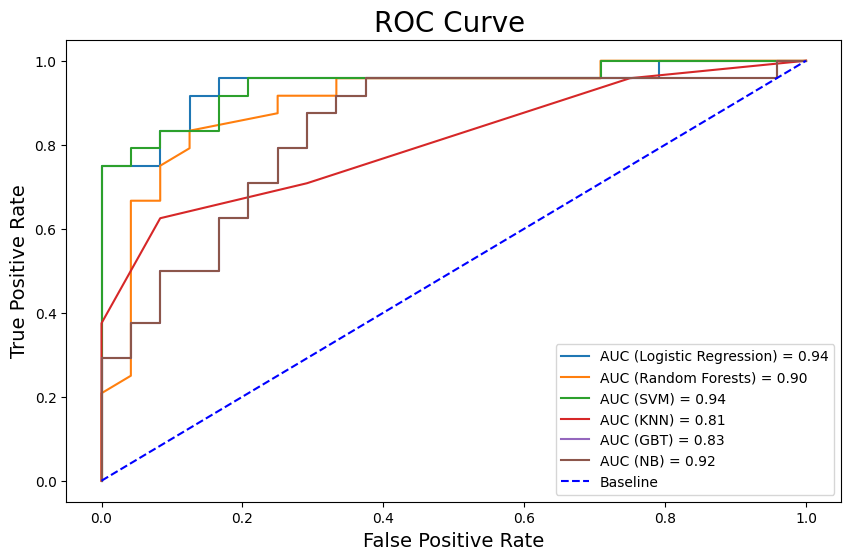

In [ ]:
# plot AUC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')
plt.plot(fpr_svm, tpr_svm, label=f'AUC (SVM) = {auc_svm:.2f}')
plt.plot(fpr_knn, tpr_knn, label=f'AUC (KNN) = {auc_knn:.2f}')
plt.plot(fpr_gbt, tpr_gbt, label=f'AUC (GBT) = {auc_gbt:.2f}')
plt.plot(fpr_gbt, tpr_gbt, label=f'AUC (NB) = {auc_NB:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve ',  size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

In [ ]:
ML_CompareTable = pd.DataFrame({
    'Model': ["LR", "RF", "SVM", "KNN", "GBT", "NB"],
    'Accuracy_Score': [Test_Accuracy_lr[0], Test_Accuracy_rf[0], Test_Accuracy_svm[0], Test_Accuracy_knn[0], Test_Accuracy_gbt[0], Test_Accuracy_NB[0]],
    'Precision_Score': [Test_Accuracy_lr[1], Test_Accuracy_rf[1], Test_Accuracy_svm[1], Test_Accuracy_knn[1], Test_Accuracy_gbt[1], Test_Accuracy_NB[1]],
    'Recall_Score': [Test_Accuracy_lr[2], Test_Accuracy_rf[2],  Test_Accuracy_svm[2],Test_Accuracy_knn[2], Test_Accuracy_gbt[2], Test_Accuracy_NB[2]],
    'F1_Score': [Test_Accuracy_lr[3], Test_Accuracy_rf[3],  Test_Accuracy_svm[3], Test_Accuracy_knn[3], Test_Accuracy_gbt[3], Test_Accuracy_NB[3]],
    'AUC': [auc_lr, auc_rf, auc_svm, auc_knn, auc_gbt, auc_NB]})

print('MODEL COMPARISON for Classical ML Models')
ML_CompareTable.sort_values(by='Accuracy_Score', ascending=False)

MODEL COMPARISON for Classical ML Models


,Model,Accuracy_Score,Precision_Score,Recall_Score,F1_Score,AUC
0,LR,0.875000,0.909091,0.833333,0.869565,0.942708
2,SVM,0.854167,0.869565,0.833333,0.851064,0.942708
1,RF,0.833333,0.785714,0.916667,0.846154,0.903646
5,NB,0.812500,0.894737,0.708333,0.790698,0.923611
4,GBT,0.791667,0.733333,0.916667,0.814815,0.833333
3,KNN,0.770833,0.882353,0.625000,0.731707,0.807292


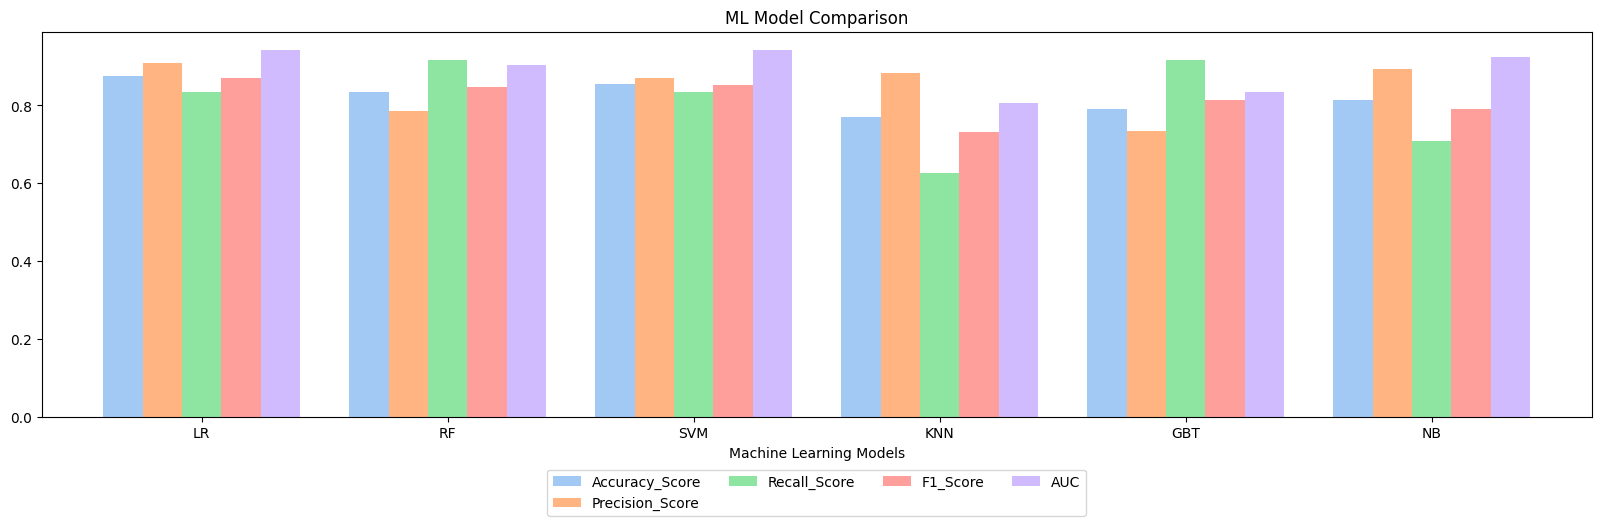

In [ ]:
# Define a light color palette (e.g., pastel colors)
light_palette = sns.color_palette("pastel")
# Define a list of light colors
#light_palette = sns.color_palette("husl", 8)
#light_palette = sns.color_palette("rocket")
#light_palette = sns.color_palette("Paired")
#light_palette = sns.color_palette("Set2")


# Plot the bar chart with the specified color palette
ax = ML_CompareTable.plot.bar(rot=0, figsize=(20, 5), width=0.8, title="ML Model Comparison", color=light_palette)
ax.set_xticklabels(ML_CompareTable['Model'])
ax.set_xlabel('Machine Learning Models')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=False, ncol=4)

plt.show()  # Display the plot

# Evaluation By Tuning Parameter using GridSearch


In [ ]:
# Evaluation By Tuning Parameter using GridSearch

# Tuning Hyper parameter by using GridSearch
def GetBestHyperParameterForModel(Model, M_scoring = 'accuracy'):
    MLmodel = None
    param_grid = {}

    if Model == 'DT':
        # Create the Decision Tree model
        MLmodel = DecisionTreeClassifier()

        # Define the parameter grid
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [10, 30, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt']
        }

    if Model == 'RF':
        MLmodel = RandomForestClassifier()

        # Define the parameter grid
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }

    if Model == 'LR':
        MLmodel = LogisticRegression()
        # Define the parameter grid
        param_grid = {
            'penalty': ['l2'],
            'C': [ 0.1, 1, 10]
        }

    if Model == 'NB':
        MLmodel = MultinomialNB()

        param_grid = {
            'alpha': [0.001, 0.01, 0.1, 1, 10]
        }


    if Model == 'SVM':
        MLmodel = svm.SVC()
        param_grid = {
            'C': [0.1, 0.5, 1, 10],  # Regularization parameter
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Type of kernel function
            'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
            'degree': [2, 3, 4]  # Degree of the polynomial kernel function
        }

    if Model == 'GBT':
        MLmodel = GradientBoostingClassifier()

        param_grid = {
            'n_estimators':[50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 10],  # Step size for weight update
            'max_depth': [3, 4, 5],  # Maximum depth of the individual trees
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
        }


    if Model == 'KNN':
        MLmodel = KNeighborsClassifier()

        param_grid = { 'n_neighbors': [3, 7, 10, 15],
                      'weights': ['uniform', 'distance'],
                      'metric': ['euclidean', 'manhattan', 'minkowski'] }


    # Perform GridSearchCV

    crossv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=42)
    grid_search = GridSearchCV(MLmodel, param_grid, cv=crossv, scoring=M_scoring, error_score=0)


    grid_search.fit(x_train, y_train)

    # Print the best parameters
    print("Best Parameters: ", grid_search.best_params_)

- We aim to enhance the accuracy of our machine learning models. To achieve this, we perform a grid search for each model, seeking the optimal hyperparameters. Subsequently, we apply these optimized parameters and iterate through the training and evaluation processes

In [ ]:
GetBestHyperParameterForModel('DT')


Best Parameters:  {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}


In [ ]:
# GetBestHyperParameterForModel('RF')


In [ ]:
GetBestHyperParameterForModel('LR')


Best Parameters:  {'C': 10, 'penalty': 'l2'}


In [ ]:
GetBestHyperParameterForModel('SVM')


Best Parameters:  {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
GetBestHyperParameterForModel('KNN')


Best Parameters:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [ ]:
# GetBestHyperParameterForModel('GBT')


In [ ]:
GetBestHyperParameterForModel('NB')


Best Parameters:  {'alpha': 0.1}


In [ ]:
GetBestHyperParameterForModel('SVM', 'roc_auc')


Best Parameters:  {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# update the function to take the new parameters
# After evaluation By Tuning Parameter using GridSearch
def ApplyBest_ML_Model( X_train, X_test, y_train, Model = 'LR'):
    ModelName = ''

    # Apply Machine learning models
    if Model == 'LR':
        ModelName = 'LogisticRegression'

        lr = LogisticRegression(C= 10,  random_state=1)
        lr.fit(X_train, y_train)
        y_predict = lr.predict(X_test)
        probs_model = lr.predict_proba(X_test)[:, 1]

    if Model == 'RF':
        ModelName = 'RandomForestClassifier'

        rf = RandomForestClassifier(criterion = 'log_loss', n_estimators= 250)
        #rf = RandomForestClassifier(criterion = 'entropy', max_depth= 30, n_estimators= 250, random_state=42)
        rf.fit(X_train, y_train)
        y_predict = rf.predict(X_test)
        probs_model = rf.predict_proba(X_test)[:, 1]


    if Model == 'NB':
        ModelName = 'MultinomialNB'
        #Best Parameters:  {'alpha': 0.1}
        # When we increase Alpha the auc will improve
        nb = MultinomialNB(alpha= 0.3)
        nb.fit(X_train, y_train)
        y_predict = nb.predict(X_test)
        probs_model = nb.predict_proba(X_test)[:, 1]

    #SVM [params: c = 1.0, kernel=RBF,gamma=scale]

    if Model == 'SVM':
        ModelName = 'Support Vector Machine'

        #Best Parameters:  {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
        svmach = svm.SVC(kernel='sigmoid',  C=0.5, probability=True, random_state=42)
        svmach.fit(X_train, y_train)
        y_predict = svmach.predict(X_test)
        probs_model = svmach.predict_proba(X_test)[:, 1]

    if Model == 'KNN':
        ModelName = 'KNeighborsClassifier'
        #Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
        knn = KNeighborsClassifier(metric = "manhattan", n_neighbors= 9)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        probs_model = knn.predict_proba(X_test)[:, 1]

    if Model == 'GBT':
        ModelName = 'GradientBoostingClassifier'
        #Best Parameters:  {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
        gbt = GradientBoostingClassifier(learning_rate= 0.3,  n_estimators= 200, random_state=42)
        gbt.fit(X_train, y_train)
        y_predict = gbt.predict(X_test)
        #y_validation_predict = gbt.predict(X_validation)
        probs_model = gbt.predict_proba(X_test)[:, 1]

    print('MachineLearning Model:',ModelName)
    print('='*100)
    return y_predict, probs_model

MachineLearning Model: LogisticRegression
+----------------------------+-------+
| LogisticRegression Scoring | Value |
+----------------------------+-------+
|          Accuracy          | 0.85  |
|      Precision_Score       | 0.84  |
|        Recall_Score        | 0.88  |
|          F1_Score          | 0.86  |
|         AUC_Score          | 0.94  |
+----------------------------+-------+
CONFUSION MATRIX


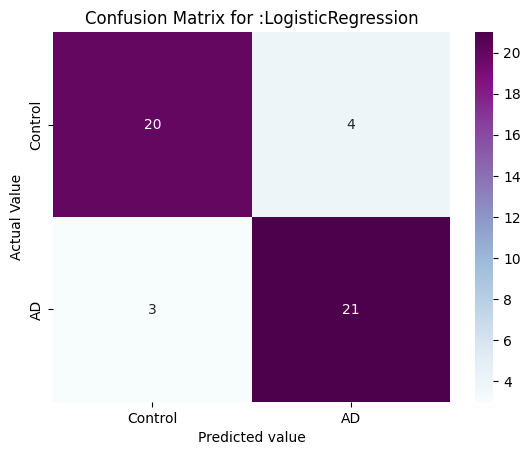

In [ ]:
# 2. Apply MachineLearning Model - Logistic Regression
Predict_LR, probs_LR = ApplyBest_ML_Model(x_train, x_test, y_train, Model = 'LR')

# 3. Evaluation the ML Model
Test_Accuracy_lr = MLModel_Evaluation(Predict_LR, y_test, probs_LR, ModelName='LogisticRegression', ShowReport = False, ConfusionMatrix=True)


MachineLearning Model: Support Vector Machine
+--------------------------------+-------+
| Support Vector Machine Scoring | Value |
+--------------------------------+-------+
|            Accuracy            | 0.90  |
|        Precision_Score         | 0.91  |
|          Recall_Score          | 0.88  |
|            F1_Score            | 0.89  |
|           AUC_Score            | 0.94  |
+--------------------------------+-------+
CONFUSION MATRIX


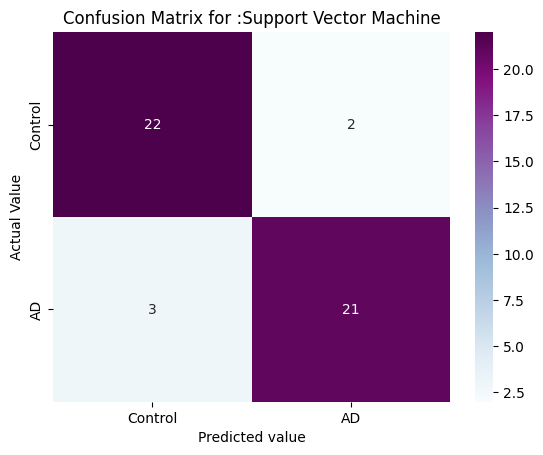

In [ ]:
## SVM
# 2. Apply MachineLearning Model - SVM:
Predict_svm, probs_SVM = ApplyBest_ML_Model(x_train, x_test, y_train, Model = 'SVM')
# 3. Evaluation the ML Model
Test_Accuracy_svm = MLModel_Evaluation(Predict_svm, y_test, probs_SVM, ModelName='Support Vector Machine',  ShowReport = False, ConfusionMatrix=True)


MachineLearning Model: KNeighborsClassifier
+------------------------------+-------+
| KNeighborsClassifier Scoring | Value |
+------------------------------+-------+
|           Accuracy           | 0.75  |
|       Precision_Score        | 0.68  |
|         Recall_Score         | 0.96  |
|           F1_Score           | 0.79  |
|          AUC_Score           | 0.87  |
+------------------------------+-------+
CONFUSION MATRIX


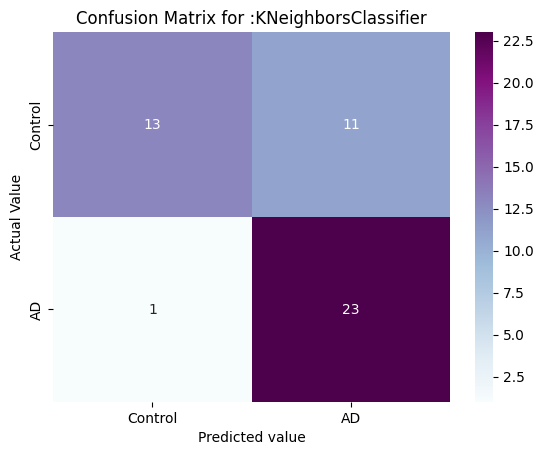

In [ ]:
# 1. Apply MachineLearning Model -KNeighborsClassifier :
Predict_KNN, probs_KNN = ApplyBest_ML_Model(x_train, x_test, y_train, Model = 'KNN')
# 2. Evaluation the ML Model
Test_Accuracy_knn = MLModel_Evaluation(Predict_KNN, y_test, probs_KNN, ModelName='KNeighborsClassifier', ShowReport = False, ConfusionMatrix=True)

MachineLearning Model: GradientBoostingClassifier
+-----------------+-------+
|   GBT Scoring   | Value |
+-----------------+-------+
|    Accuracy     | 0.79  |
| Precision_Score | 0.75  |
|  Recall_Score   | 0.88  |
|    F1_Score     | 0.81  |
|    AUC_Score    | 0.84  |
+-----------------+-------+
CONFUSION MATRIX


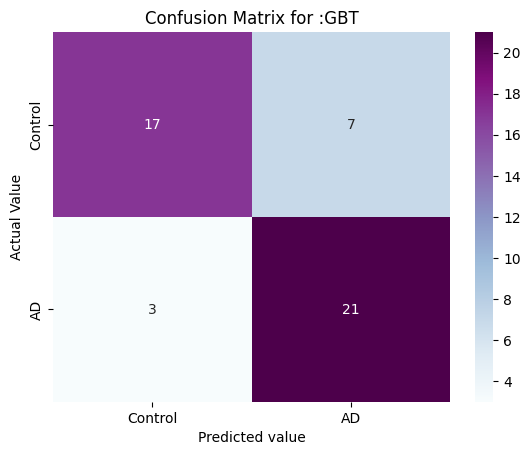

In [ ]:
Predict_GBT, probs_GBT = ApplyBest_ML_Model(x_train, x_test, y_train, Model = 'GBT')
# 2. Evaluation the ML Model
Test_Accuracy_gbt = MLModel_Evaluation(Predict_GBT, y_test, probs_GBT, ModelName='GBT', ShowReport = False, ConfusionMatrix=True)


MachineLearning Model: RandomForestClassifier
+----------------------+-------+
| RandomForest Scoring | Value |
+----------------------+-------+
|       Accuracy       | 0.81  |
|   Precision_Score    | 0.78  |
|     Recall_Score     | 0.88  |
|       F1_Score       | 0.82  |
|      AUC_Score       | 0.89  |
+----------------------+-------+
CONFUSION MATRIX


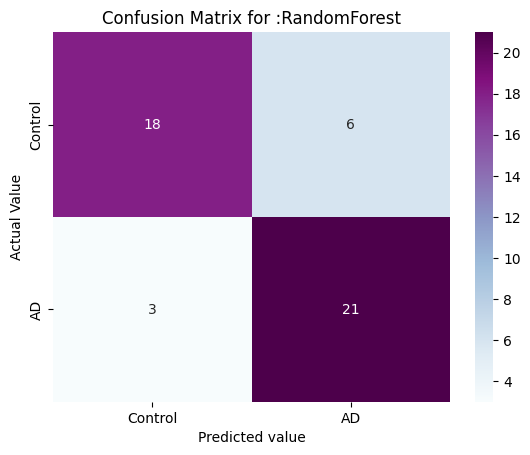

In [ ]:
# 2.Random Forest -RF
# best result when using random_state
Predict_RF, probs_RF = ApplyBest_ML_Model(x_train, x_test, y_train, Model = 'RF')
Test_Accuracy_rf = MLModel_Evaluation(Predict_RF, y_test, probs_RF, ModelName='RandomForest', ShowReport = False, ConfusionMatrix=True)
print("="*100)

MachineLearning Model: RandomForestClassifier
+----------------------+-------+
| RandomForest Scoring | Value |
+----------------------+-------+
|       Accuracy       | 0.85  |
|   Precision_Score    | 0.81  |
|     Recall_Score     | 0.92  |
|       F1_Score       | 0.86  |
|      AUC_Score       | 0.90  |
+----------------------+-------+
CONFUSION MATRIX


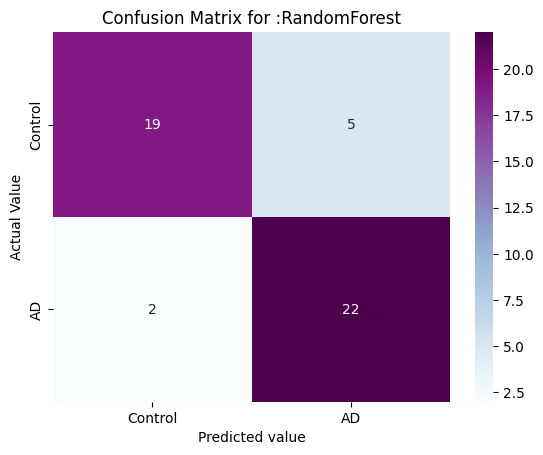

In [ ]:
# 2.Random Forest -RF without using random_state
Predict_RF, probs_RF = ApplyBest_ML_Model(x_train, x_test, y_train, Model = 'RF')
Test_Accuracy_rf = MLModel_Evaluation(Predict_RF, y_test, probs_RF, ModelName='RandomForest', ShowReport = False, ConfusionMatrix=True)
print("="*100)

MachineLearning Model: MultinomialNB
+--------------------+-------+
| NaiveBayes Scoring | Value |
+--------------------+-------+
|      Accuracy      | 0.81  |
|  Precision_Score   | 0.89  |
|    Recall_Score    | 0.71  |
|      F1_Score      | 0.79  |
|     AUC_Score      | 0.91  |
+--------------------+-------+
CONFUSION MATRIX


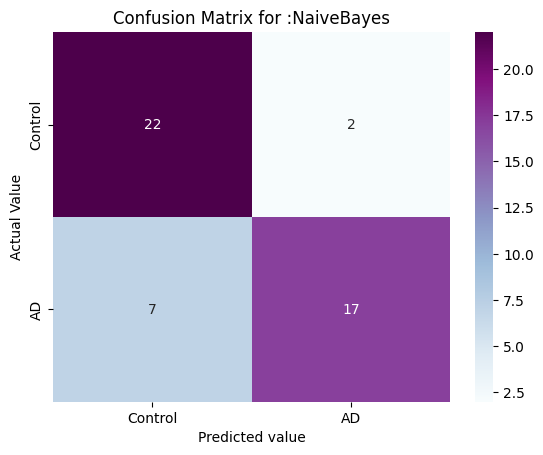

In [ ]:
#  NB
Predict_NB, probs_NB = ApplyBest_ML_Model(x_train, x_test, y_train, Model = 'NB')
Test_Accuracy_NB = MLModel_Evaluation(Predict_NB, y_test, probs_NB, ModelName='NaiveBayes', ShowReport = False, ConfusionMatrix=True)
print("="*100)

In [ ]:
# Preparing for Plotting AUC curve

auc_lr = roc_auc_score(y_test, probs_LR)
fpr_lr, tpr_lr, _ = roc_curve(y_test, probs_LR)

auc_rf = roc_auc_score(y_test, probs_RF)
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_RF)

auc_svm = roc_auc_score(y_test, probs_SVM)
fpr_svm, tpr_svm, _ = roc_curve(y_test, probs_SVM)

auc_knn = roc_auc_score(y_test, probs_KNN)
fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_KNN)

auc_gbt = roc_auc_score(y_test, probs_GBT)
fpr_gbt, tpr_gbt, _ = roc_curve(y_test,probs_GBT)

auc_NB = roc_auc_score(y_test, probs_NB)
fpr_NB, tpr_NB, _ = roc_curve(y_test,probs_NB)

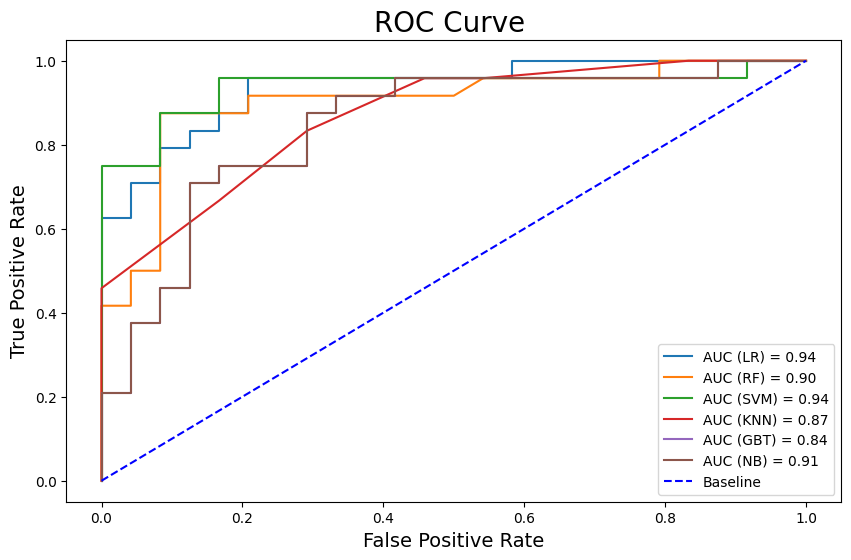

In [ ]:
# plot AUC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (LR) = {auc_lr:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (RF) = {auc_rf:.2f}')
plt.plot(fpr_svm, tpr_svm, label=f'AUC (SVM) = {auc_svm:.2f}')
plt.plot(fpr_knn, tpr_knn, label=f'AUC (KNN) = {auc_knn:.2f}')
plt.plot(fpr_gbt, tpr_gbt, label=f'AUC (GBT) = {auc_gbt:.2f}')
plt.plot(fpr_gbt, tpr_gbt, label=f'AUC (NB) = {auc_NB:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve ',  size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

In [ ]:
ML_CompareTable = pd.DataFrame({
    'Model': ["LR", "RF", "SVM", "KNN", "GBT", "NB"],
    'Accuracy': [round(Test_Accuracy_lr[0],2), round(Test_Accuracy_rf[0],2), round(Test_Accuracy_svm[0],2), round(Test_Accuracy_knn[0],2), round(Test_Accuracy_gbt[0],2), round(Test_Accuracy_NB[0],2)],
    'Precision': [round(Test_Accuracy_lr[1],2), round(Test_Accuracy_rf[1],2), round(Test_Accuracy_svm[1],2), round(Test_Accuracy_knn[1],2), round(Test_Accuracy_gbt[1],2), round(Test_Accuracy_NB[1],2)],
    'Recall': [round(Test_Accuracy_lr[2],2), round(Test_Accuracy_rf[2],2), round(Test_Accuracy_svm[2],2), round(Test_Accuracy_knn[2],2), round(Test_Accuracy_gbt[2],2), round(Test_Accuracy_NB[2],2)],
    'F1_Score': [round(Test_Accuracy_lr[3],2), round(Test_Accuracy_rf[3],2), round(Test_Accuracy_svm[3],2), round(Test_Accuracy_knn[3],2), round(Test_Accuracy_gbt[3],2), round(Test_Accuracy_NB[3],2)],
    'AUC': [round(auc_lr,2), round(auc_rf,2), round(auc_svm,2), round(auc_knn,2), round(auc_gbt,2), round(auc_NB,2)]})



print('MODEL COMPARISON for Classical ML Models after Tunning')
ML_CompareTable.sort_values(by='Accuracy', ascending=False)

MODEL COMPARISON for Classical ML Models after Tunning


,Model,Accuracy,Precision,Recall,F1_Score,AUC
2,SVM,0.90,0.91,0.88,0.89,0.94
0,LR,0.85,0.84,0.88,0.86,0.94
1,RF,0.85,0.81,0.92,0.86,0.90
5,NB,0.81,0.89,0.71,0.79,0.91
4,GBT,0.79,0.75,0.88,0.81,0.84
3,KNN,0.75,0.68,0.96,0.79,0.87


In [ ]:
ML_CompareAccuracy =  ML_CompareTable[['Model','Accuracy', 'AUC']]
ML_CompareAccuracy.head()

,Model,Accuracy,AUC
0,LR,0.85,0.94
1,RF,0.85,0.90
2,SVM,0.90,0.94
3,KNN,0.75,0.87
4,GBT,0.79,0.84


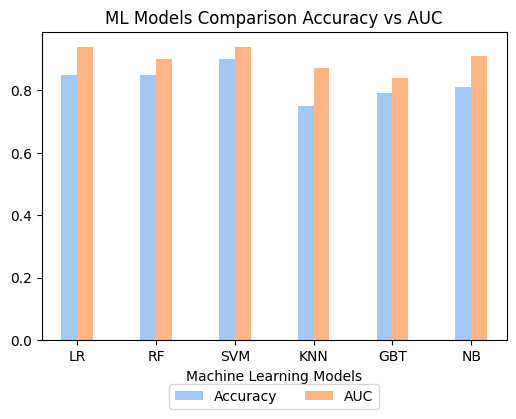

In [ ]:
# Define a light color palette (e.g., pastel colors)
light_palette = sns.color_palette("pastel")

# Plot the bar chart with the specified color palette
ax = ML_CompareAccuracy.plot.bar(rot=0, figsize=(6, 4), width=0.4, title="ML Models Comparison Accuracy vs AUC", color=light_palette)
ax.set_xticklabels(ML_CompareTable['Model'])
ax.set_xlabel('Machine Learning Models')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=False, ncol=2)

plt.show()

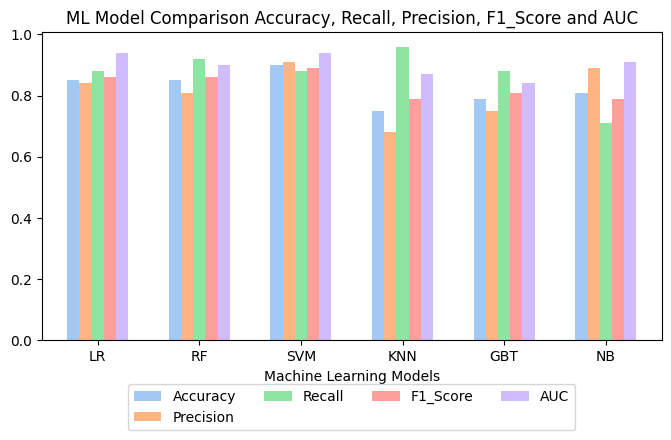

In [ ]:


# Define a light color palette (e.g., pastel colors)
light_palette = sns.color_palette("pastel")
# Define a list of light colors
#light_palette = sns.color_palette("husl", 8)
#light_palette = sns.color_palette("rocket")
#light_palette = sns.color_palette("Paired")
#light_palette = sns.color_palette("Set2")


# Plot the bar chart with the specified color palette
ax = ML_CompareTable.plot.bar(rot=0, figsize=(8, 4), width=0.6, title="ML Model Comparison Accuracy, Recall, Precision, F1_Score and AUC", color=light_palette)
ax.set_xticklabels(ML_CompareTable['Model'])
ax.set_xlabel('Machine Learning Models')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=False, ncol=4)

plt.show()

In [ ]:
# # Now save the cleaned training dataset into a new csv - cleaned_training.csv
# df_training.to_csv('/content/drive/MyDrive/ADReSS /cleaned_training.csv', index=False)
# # Save the cleaned testing data into a new csv.
# df_testing.to_csv('/content/drive/MyDrive/ADReSS /cleaned_testing.csv', index=False)